In [66]:
import numpy as np
import pandas as pd

import random
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader

In [67]:
torch.manual_seed(0)

In [68]:
seq_length = 7 # 7일간의 데이터가 입력 후 8일째 데이터 예측
data_dim = 5 # 시가, 최고가, 최저가, 거래량, 종가
hidden_dim = 10 # 임의의로 설정
output_dim = 1 # 마지막에 fc layer가 맞춰야하는 종가의 차원
learning_rate = 0.01
iterations = 500

In [69]:
df = pd.read_csv('stock_data.csv') # 데이터 불러오기
df = df[::-1] # 역순으로 정렬

# 학습데이터 7 : 테스트데이터 3
train_size = int(len(df)*0.7)
train_set = df[0:train_size]
test_set = df[train_size-seq_length:]

In [70]:
# 입력 스케일링
scaler_x = MinMaxScaler()
scaler_x.fit(train_set.iloc[:,:-1])
train_set.iloc[:,:-1] = scaler_x.transform(train_set.iloc[:,:-1])
test_set.iloc[:,:-1] = scaler_x.transform(test_set.iloc[:,:-1])

# 출력 스케일링(fit,transform의 입력값에는 2D Dataframe 필요)
scaler_y = MinMaxScaler()
scaler_y.fit(train_set.iloc[:,[-1]])
train_set.iloc[:,-1] = scaler_y.transform(train_set.iloc[:,[-1]])
test_set.iloc[:,-1] = scaler_y.transform(test_set.iloc[:,[-1]])

/var/folders/xj/_swws2td1j333fqkjhr5tmjr0000gn/T/ipykernel_4582/3338449098.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_set.iloc[:,:-1] = scaler_x.transform(train_set.iloc[:,:-1])
/var/folders/xj/_swws2td1j333fqkjhr5tmjr0000gn/T/ipykernel_4582/3338449098.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_set.iloc[:,:-1] = scaler_x.transform(test_set.iloc[:,:-1])
/var/folders/xj/_swws2td1j333fqkjhr5tmjr0000gn/T/ipykernel_4582/3338449098.py:10: SettingWithCopyWarning: 
A value is trying to 

In [71]:
def build_dataset(time_series, seq_length):
    dataX = []
    dataY = []
    for i in range(0, len(time_series)-seq_length):
        _x = time_series[i:i+seq_length,:]
        _y = time_series[i+seq_length,[-1]]
        dataX.append(_x)
        dataY.append(_y)
    return np.array(dataX), np.array(dataY)

# 데이터셋 생성
trainX, trainY = build_dataset(np.array(train_set), seq_length)
testX, testY = build_dataset(np.array(test_set), seq_length)

In [72]:
# 텐서로 변환
trainX_tensor = torch.FloatTensor(trainX)
trainY_tensor = torch.FloatTensor(trainY)
testX_tensor = torch.FloatTensor(testX)
testY_tensor = torch.FloatTensor(testY)

In [73]:
class Net(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, layers):
        super(Net, self).__init__()
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers=layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim, bias=True)

    # 예측
    def forward(self, x):
        # x shape: (batch_size, time_steps, input_size)
        x, _status = self.lstm(x) # 모든 시점의 은닉 상태 x shape: (batch_size, time_steps, hidden_dim), 마지막 시점의 은닉 상태 _status  
        x = self.fc(x[:,-1]) # 마지막 시점의 은닉 상태 x[:,-1] shape: (batch_size, hidden_dim)
        return x

net = Net(data_dim, hidden_dim, output_dim, 1)

In [74]:
criterion = nn.MSELoss()
optimizer = optim.Adam(net.parameters(), learning_rate)

In [75]:
for i in range(iterations):
    optimizer.zero_grad()
    outputs = net(trainX_tensor)
    loss = criterion(outputs, trainY_tensor)
    loss.backward()
    optimizer.step()
    print(i, loss.item())

0 0.22912731766700745
1 0.18586930632591248
2 0.15383325517177582
3 0.12927718460559845
4 0.10958041250705719
5 0.0931888148188591
6 0.07939716428518295
7 0.06810388714075089
8 0.05959073081612587
9 0.054255302995443344
10 0.052164290100336075
11 0.05247679352760315
12 0.053493138402700424
13 0.0535382404923439
14 0.05162598192691803
15 0.04760899022221565
16 0.04202478751540184
17 0.03576363995671272
18 0.02970152348279953
19 0.02444535866379738
20 0.02025364525616169
21 0.017096063122153282
22 0.014770431444048882
23 0.013020838610827923
24 0.011638114228844643
25 0.0105317123234272
26 0.009746520780026913
27 0.00939805805683136
28 0.009543679654598236
29 0.01007168460637331
30 0.010707048699259758
31 0.01114506646990776
32 0.011200308799743652
33 0.010860132984817028
34 0.010241853073239326
35 0.009513654746115208
36 0.008826209232211113
37 0.008273251354694366
38 0.007882149890065193
39 0.0076278820633888245
40 0.0074599855579435825
41 0.007330362685024738
42 0.007211402989923954
4

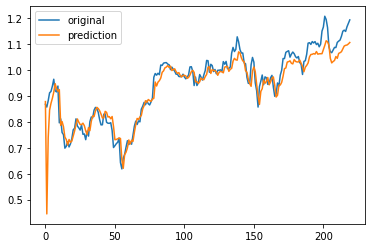

In [76]:
plt.plot(testY)
plt.plot(net(testX_tensor).data.numpy())
plt.legend(['original','prediction'])
plt.show()